In [31]:
from preprocessor import get_paths, get_multiclass_paths
from numpy.random import shuffle
from tqdm import tqdm
import numpy as np
import cv2
import json
import torch
from os import listdir
from collections import Counter
from os.path import isfile, join
import matplotlib.pyplot as plt

In [24]:
description_paths, image_paths = get_paths('raw_data/Descriptions', 'raw_data/Images')

## 1.1 Image examples

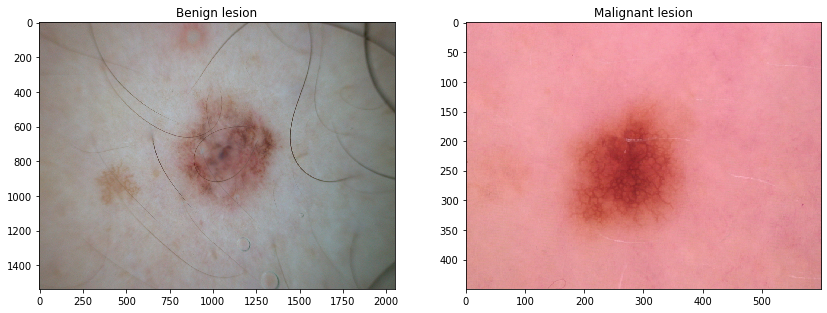

In [4]:
plt.subplots(figsize=(14,16))
plt.subplot(1,2,1)
plt.imshow(cv2.imread(image_paths[0])[:,:,::-1])
plt.title("Benign lesion")

plt.subplot(1,2,2)
plt.imshow(cv2.imread(image_paths[1499])[:,:,::-1])
plt.title("Malignant lesion")
plt.show()

## 1.2 Class imbalance
There is a major class imbalance - only 10.5% of the images are malignant. Possible ways to address this include data augmentation, weighted objective function, and/or positive class image synthesis with GANs.

In [25]:
# What is the class imbalance?
Y=[]
for path in description_paths:
    with open (path, "r") as file:
        label = file.read().replace('\n', '')
        Y.append(json.loads(label)['meta']['clinical']['benign_malignant'])
Y = np.asarray([1 if diagnosis=='malignant' else 0 for diagnosis in Y])
p = np.sum(Y)/len(Y)

malignant = np.sum(Y)
benign = len(description_paths) - malignant
benign/malignant

8.489501312335959

In [ ]:
len(description_paths)/malignant

In [37]:
diagnoses = []
for ID in listdir('raw_data/Descriptions'):
    with open (join('raw_data/Descriptions', ID), "r") as file:
        data = file.read().replace('\n', '')
        try:
            diagnoses.append(json.loads(data)['meta']['clinical']['diagnosis'])
        except:
            continue
            
from collections import Counter
cnt = Counter(diagnoses)
cnt

Counter({'nevus': 18566,
         'melanoma': 2169,
         'pigmented benign keratosis': 1099,
         'basal cell carcinoma': 586,
         'squamous cell carcinoma': 226,
         'seborrheic keratosis': 419,
         'lentigo simplex': 27,
         'actinic keratosis': 132,
         'lentigo NOS': 71,
         'dermatofibroma': 122,
         'vascular lesion': 142,
         None: 66,
         'solar lentigo': 57,
         'atypical melanocytic proliferation': 13,
         'angioma': 15,
         'other': 10,
         'angiofibroma or fibrous papule': 1,
         'lichenoid keratosis': 1,
         'scar': 1})

In [47]:
sum([count for diagnosis, count in cnt.most_common(9)])

23461

In [22]:
['nevus', 'melanoma', 'pigmented benign keratosis', 'basal cell carcinoma', 'seborrheic keratosis', 'squamous cell carcinoma']

['nevus',
 'melanoma',
 'pigmented benign keratosis',
 'basal cell carcinoma',
 'seborrheic keratosis',
 'squamous cell carcinoma']

In [25]:
cnt.most_common(6)

[('nevus', 18566),
 ('melanoma', 2169),
 ('seborrheic keratosis', 419),
 ('lentigo NOS', 71),
 ('basal cell carcinoma', 68),
 ('solar lentigo', 57)]

In [23]:
sum([count for d, count in cnt.most_common(6)])

21350

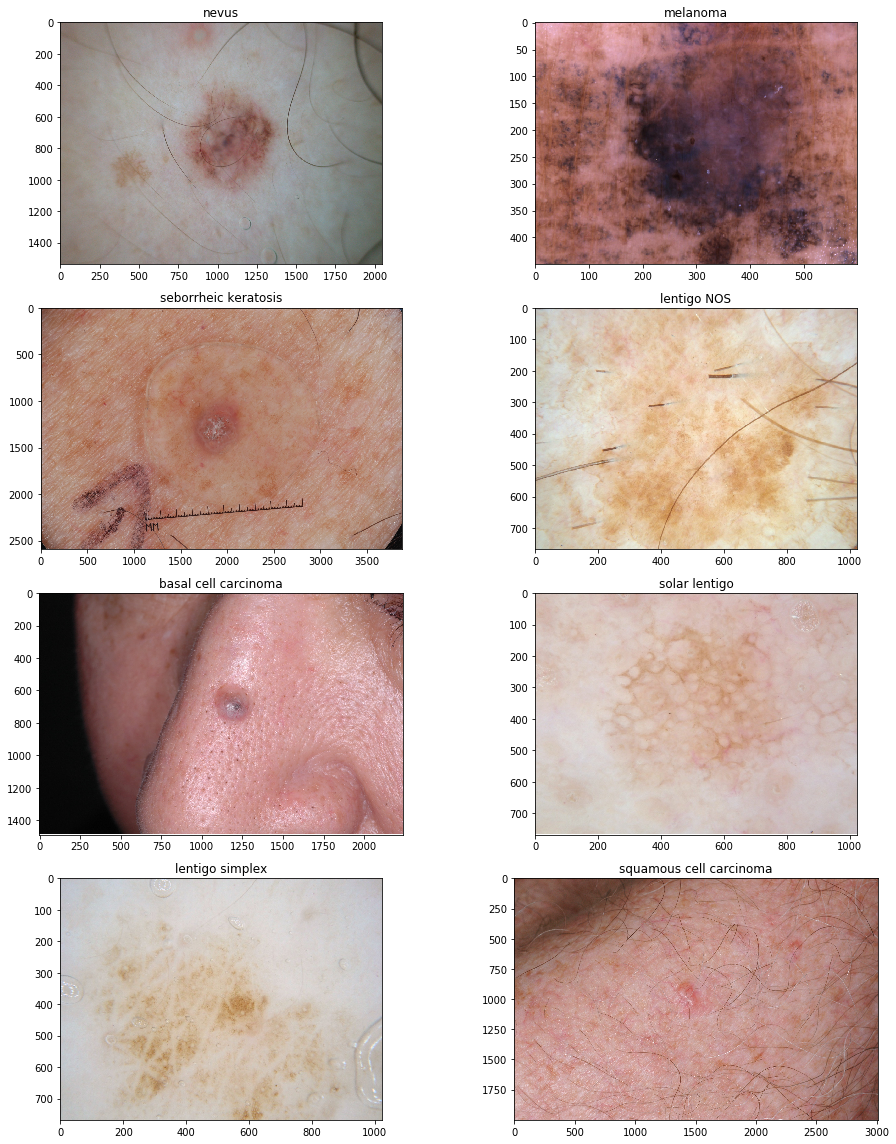

In [36]:
classes = list(dict(cnt.most_common(8)).keys())
plt.subplots(figsize=(14,16))
for i,index in enumerate(indices):
    plt.subplot(4,2,i+1)
    plt.imshow(cv2.imread(image_paths[index])[:,:,::-1])
    plt.title(classes[i])

plt.tight_layout()
plt.show()

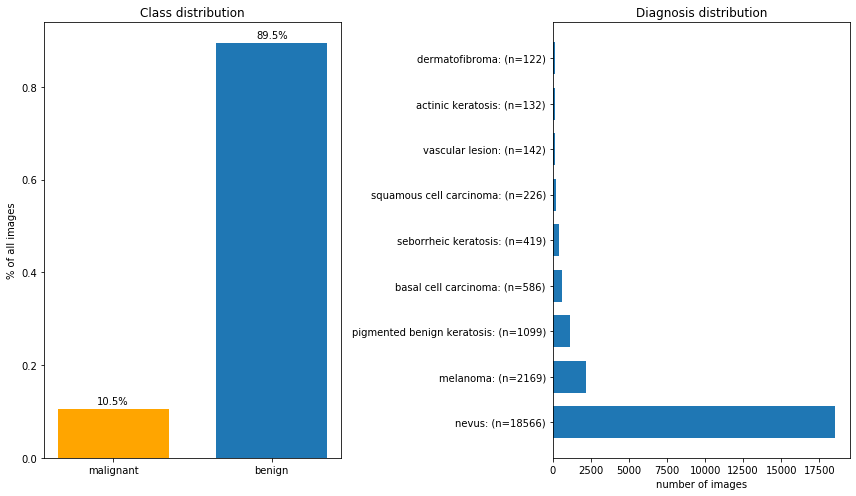

In [48]:
labels = ['malignant', 'benign']
heights = [p, 1-p]

x = np.arange(len(labels))  # the label locations
width = 0.7  # the width of the bars

fig, ax = plt.subplots(1,2,figsize=(12,7))
rects1 = ax[0].bar(x, heights, width, color=['orange','#1f77b4'])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax[0].set_ylabel('% of all images')
ax[0].set_title('Class distribution')
ax[0].set_xticks(x)
ax[0].set_xticklabels(labels)

def autolabel(rects,i):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        if i==0:
            ax[i].annotate(
                           '{}'.format(
                           '%.1f'%(100*height) + '%'),
                           xy=(rect.get_x() + rect.get_width()/2, height),
                           xytext=(0, 3), textcoords="offset points",
                           ha='center', va='bottom')
        else:
            ax[i].annotate(
                          '{}'.format(height),
                           xy=(rect.get_x() + rect.get_width()/2, height),
                           xytext=(0, 3),  # 3 points vertical offset
                           textcoords="offset points",
                           ha='center', va='bottom')

autolabel(rects1,0)

rects2 = ax[1].barh(range(9), [class_dict[key] for key in class_dict], width)
ax[1].set_xlabel('number of images')
ax[1].set_title('Diagnosis distribution')
ax[1].set_yticks(range(9))
ax[1].set_yticklabels(['{}: (n={})'.format(key, class_dict[key]) for key in class_dict])
# autolabel(rects2,1)


fig.tight_layout()

plt.show()

## 1.3 Image Shapes
A scatter plot of image shapes

In [ ]:
shapes=[]
for path in tqdm(image_paths):
    # resize the images to the computed mean aspect ratio using cv2
    image = cv2.imread(path)
    shapes.append(image.shape)
shapes

In [78]:
heights = [shape[0] for shape in shapes]
widths = [shape[1] for shape in shapes]

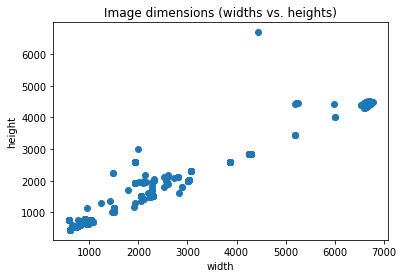

In [80]:
plt.scatter(widths, heights)
plt.title("Image dimensions (widths vs. heights)")
plt.xlabel("width")
plt.ylabel("height")
plt.show()

## 1.4 Image histograms
Histogram of the rgb values. On a 2169-image sample.

In [21]:
X = torch.load('data/images-0.pt')

In [22]:
r = X[:,0,:,:].flatten()
g = X[:,1,:,:].flatten()
b = X[:,2,:,:].flatten()

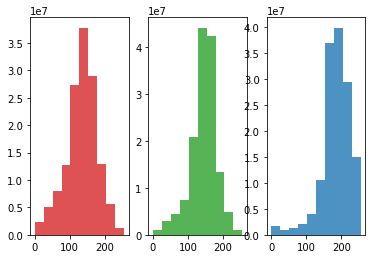

In [23]:
plt.subplot(1,3,1)
plt.hist(r, color='C3', alpha=.8)

plt.subplot(1,3,2)
plt.hist(g, color='C2', alpha=.8)

plt.subplot(1,3,3)
plt.hist(b, color='C0', alpha=.8)
plt.show()

## 2. Multiclassification
### 2.1 Class distribution

In [2]:
description_paths, image_paths, class_dict = get_multiclass_paths('raw_data/Descriptions', 'raw_data/Images')

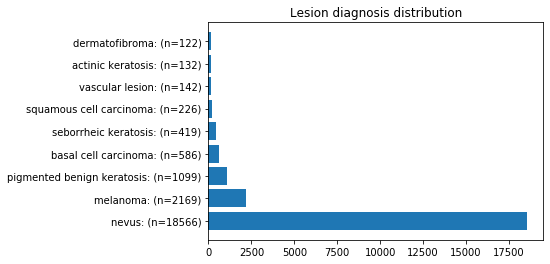

In [22]:
plt.barh(range(9), [class_dict[key] for key in class_dict])
plt.yticks(range(9), ['{}: (n={})'.format(key, class_dict[key]) for key in class_dict])
# plt.xticks([class_dict[key] for key in class_dict])
plt.title("Lesion diagnosis distribution")
plt.show()

In [39]:
diagnoses=[]
descriptions_dir = 'raw_data/Descriptions'
for ID in listdir(descriptions_dir):
        with open (join(descriptions_dir, ID), "r") as file:
            data = file.read().replace('\n', '')
            try:
                diagnoses.append(json.loads(data)['meta']['clinical']['diagnosis'])
            except:
                continue

In [42]:
cnt=Counter(diagnoses).most_common(19)

In [43]:
cnt

[('nevus', 18566),
 ('melanoma', 2169),
 ('pigmented benign keratosis', 1099),
 ('basal cell carcinoma', 586),
 ('seborrheic keratosis', 419),
 ('squamous cell carcinoma', 226),
 ('vascular lesion', 142),
 ('actinic keratosis', 132),
 ('dermatofibroma', 122),
 ('lentigo NOS', 71),
 (None, 66),
 ('solar lentigo', 57),
 ('lentigo simplex', 27),
 ('angioma', 15),
 ('atypical melanocytic proliferation', 13),
 ('other', 10),
 ('angiofibroma or fibrous papule', 1),
 ('lichenoid keratosis', 1),
 ('scar', 1)]